# Assignment-3 COMP-5630 Jacob Murrah
## README
This notebook implements natural language processing tasks focusing on word embeddings, n-gram classification, and sequence-to-sequence models for text summarization. It explores different embedding techniques, evaluates n-gram features for classification, and implements RNN-based models for summarizing legislative text.

## Dependencies
- **Python 3.x**
- **matplotlib**
- **seaborn**
- **nltk**
- **numpy==1.26.4**
- **torch==2.2.2**
- **transformers==4.50.3**
- **datasets==2.18.0**
- **scipy==1.12.0**
- **pandas==2.1.4**
- **scikit-learn==1.4.0**
- **gensim==4.3.2**
- **evaluate==0.4.1**

## Instructions
1) Run the cell with the skip cell magic function defined. Marked with the # SKIP MAGIC FUNCTION comment.
2) Run the cell beginning with %%skip and marked with the # DOWNLOAD PACKAGES CELL comment.
3) After downloads are complete the runtime will be disconnected and you will see an associated message.
4) Reconnect the runtime and click on \"Runtime\" > \"Run all\" to execute the entire notebook sequentially.
6) The notebook is organized into several sections. Ensure that all cells run without errors.

In [3]:
SKIP_INSTALL = True

In [4]:
# SKIP MAGIC FUNCTION
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
  if globals().get('SKIP_INSTALL', False):
    print("Skipping installation cell.")
  else:
    get_ipython().run_cell(cell)

In [5]:
# SKIP_INSTALL = False

In [6]:
%%skip
# DOWNLOAD PACKAGES CELL
import contextlib
import io
import time
import sys
import subprocess
import re
import os

def capture_output():
  return contextlib.redirect_stdout(io.StringIO())

print("Downloads take ~5 minutes but are required for version compatiability!")
time.sleep(1)

with capture_output():
  package_versions = {
    "numpy": "1.26.4",
    "torch": "2.2.2",
    "transformers": "4.50.3",
    "datasets": "2.18.0",
    "scipy": "1.12.0",
    "pandas": "2.1.4",
    "scikit-learn": "1.4.0",
    "gensim": "4.3.2",
    "evaluate": "0.4.1"
  }

  # get cuda version
  cuda_version_str = "N/A"
  cuda_major_minor = None
  nvcc_output = subprocess.check_output(['nvcc', '--version']).decode('utf-8')
  match_obj = re.search(r'release (\d+\.\d+)', nvcc_output)
  if match_obj:
    cuda_version_str = match_obj.group(1)
    cuda_major_minor = "".join(cuda_version_str.split('.'))

  # pytorch installation
  pytorch_version = package_versions["torch"]
  pytorch_cuda_suffix = "cu118"
  if cuda_major_minor and int(cuda_major_minor) >= 121:
    pytorch_cuda_suffix = "cu121"

  torchvision_version = "0.17.2"
  torchaudio_version = "2.2.2"
  pytorch_index_url = f"https://download.pytorch.org/whl/{pytorch_cuda_suffix}"

  pytorch_install_command = (
    f"pip3 install "
    f"torch=={pytorch_version}+{pytorch_cuda_suffix} "
    f"torchvision=={torchvision_version}+{pytorch_cuda_suffix} "
    f"torchaudio=={torchaudio_version}+{pytorch_cuda_suffix} "
    f"--index-url {pytorch_index_url} --upgrade --no-cache-dir"
  )
  get_ipython().system(pytorch_install_command)

  # install specified packages
  get_ipython().system('pip3 uninstall transformers -y')
  packages_to_install = [
    f"{pkg}=={ver}" for pkg, ver in package_versions.items() if pkg != "torch"
  ]
  other_packages_install_command = (
    "pip3 install --upgrade --no-cache-dir " + " ".join(packages_to_install)
  )

  get_ipython().system(other_packages_install_command)
  get_ipython().system(
    'pip install "huggingface_hub[hf_xet]" --upgrade --no-cache-dir'
  )

# restart environment
print("Package installation completed successfully!")
os._exit(0)

Skipping installation cell.


In [7]:
# basic imports
import gensim
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import importlib.metadata
import sys
version = importlib.metadata.version("torch")
print(version)

2.2.2+cu118


# Part 1. Word Embeddings and N-gram

In [8]:
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer

import gensim.downloader as api
from gensim.models import FastText, Word2Vec
from gensim.test.utils import datapath

from sklearn.metrics.pairwise import cosine_similarity

import re
import string

## Part 1. (1a-1b) You will examine two-word embeddings. You are given the following words:

Dog, Bark, Tree, Bank, River, Money.

Do the following:
- Use Glove-twitter-50D word2vec and compute nxn matrices using cosine similarities for the given words.
- Use FastText and compute nxn matrices using cosine similarities for the given words.

In [9]:
# download glove-twitter-50 model
nltk.download("twitter_samples")
nltk.download('stopwords')
if "glove" not in globals():
  glove = api.load("glove-twitter-50")

print("downloads completed!")

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jmurrah/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jmurrah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


downloads completed!


In [10]:
# data preprocessing
# https://www.kaggle.com/code/piyushagni5/sentiment-analysis-on-twitter-dataset-nlp
def process_tweet(tweet):
  stemmer = PorterStemmer()
  stopwords_english = stopwords.words('english')

  tweet = re.sub(r'\$\w*', '', tweet)
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)

  tokenizer = TweetTokenizer(
    preserve_case=False, strip_handles=True, reduce_len=True
  )
  tweet_tokens = tokenizer.tokenize(tweet)

  tweets_clean = []
  for word in tweet_tokens:
    if (word not in stopwords_english and word not in string.punctuation):
      stem_word = stemmer.stem(word)
      tweets_clean.append(stem_word)

  return tweets_clean

negative_tweets = twitter_samples.strings("negative_tweets.json")
positive_tweets = twitter_samples.strings("positive_tweets.json")
common_texts = [
  process_tweet(tweet)
  for tweet_list in [negative_tweets, positive_tweets]
  for tweet in tweet_list
]
print(f"Number of tweets: {len(common_texts)}")

Number of tweets: 10000


In [11]:
# train the Word2Vec and FastText models
# NOTE: our GloVe w2v model is already loaded
if "w2v" not in globals():
  w2v = Word2Vec(sentences=common_texts, vector_size=50, window=5, min_count=1)
if "ft" not in globals():
  ft = FastText(
    vector_size=50, window=5, min_count=1, sentences=common_texts, epochs=10
  )
print("done training models!")

done training models!


In [12]:
# create similarity matrices of the words for each model
def create_similarity_matrix(model, words, glove_model=False):
  if glove_model:
    common_text_words = set([word for text in common_texts for word in text])
    glove_words = [
      word.lower() for word in glove.key_to_index
      if word.lower() in common_text_words
    ]
    words_in_model = [w for w in words if w in glove_words]
  else:
    words_in_model = [w for w in words if w in model.wv]

  word_vectors = np.array(
    [
      model.get_vector(word) if glove_model else model.wv[word]
      for word in words_in_model
    ]
  )
  similarity_matrix = cosine_similarity(word_vectors)
  return similarity_matrix, words_in_model

words = ["dog", "bark", "tree", "bank", "river", "money"]
glove_matrix, words_in_glove = create_similarity_matrix(
  glove, words, glove_model=True
)
w2v_matrix, words_in_w2v = create_similarity_matrix(w2v, words)
ft_matrix, words_in_ft = create_similarity_matrix(ft, words)

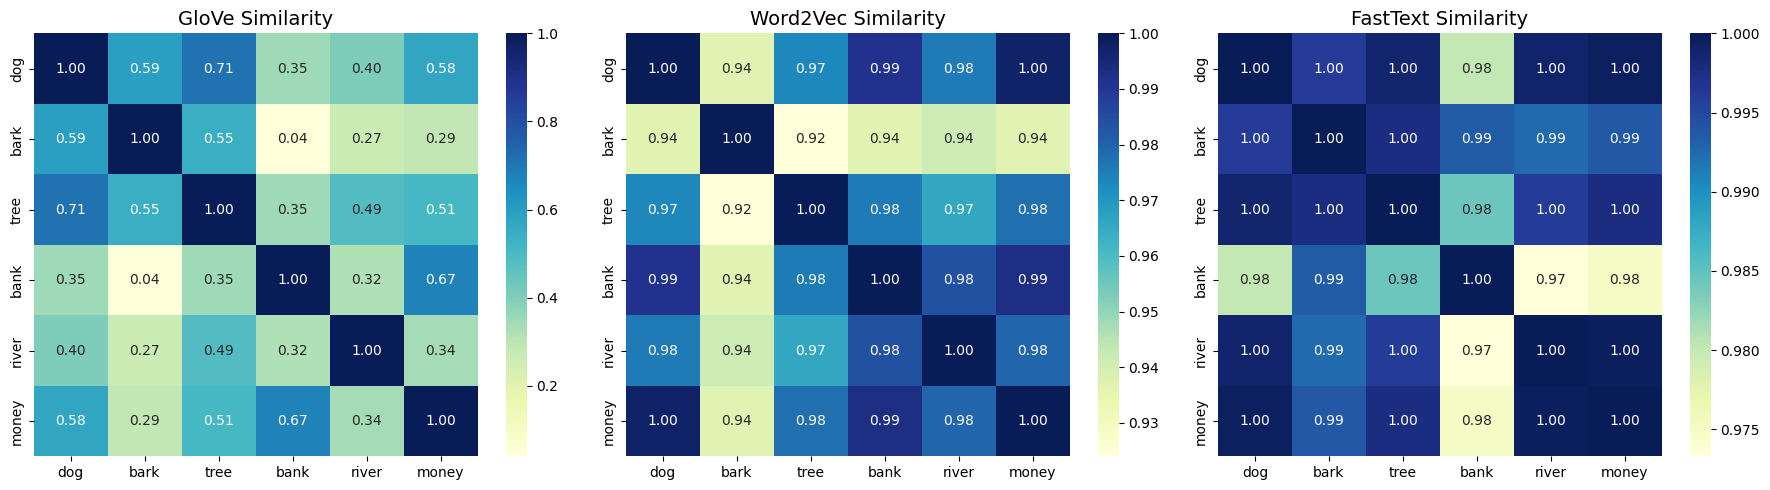

In [13]:
# plot the similarity matrices for each model
def plot_similarity_matrices(matrices, words_lists, titles):
  n = len(matrices)
  fig, axes = plt.subplots(1, n, figsize=(n * 6, 5))
  for i in range(n):
    sns.heatmap(
      matrices[i],
      annot=True,
      fmt=".2f",
      cmap="YlGnBu",
      xticklabels=words_lists[i],
      yticklabels=words_lists[i],
      ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=14)

  plt.tight_layout()
  plt.show()

matrices = [glove_matrix, w2v_matrix, ft_matrix]
words_lists = [words_in_glove, words_in_w2v, words_in_ft]
titles = ["GloVe Similarity", "Word2Vec Similarity", "FastText Similarity"]
plot_similarity_matrices(matrices, words_lists, titles)

## Part 1. (1c) Which embedding captures better semantics? Justify your answer.<br>
**Answer:** Based on the similarity scores between the 6 words, the GloVe model is better at capturing the semantics, i.e the meaning, of the words. The FastText model is a close second. Since there is not a universal standard similarity score for these specific word pairs I am using my own understanding of the english language to evaluate.

Words with multiple meanings:
- Bark: Dog barking or tree bark
- Bank: River bank or a bank that manages money

Related pairs:
- Dog-Bark
- Tree-Bark
- Money-Bank
- River-Bank

Model Evaluation:
- **GloVe:** The similarity matrix shows clear differentiation between semantically distinct words. For example, the similarity between “bark” and “bank” is extremely low and the similarity between "money" and "bank" is relatively high.
- **Word2Vec:** Shows high similarity scores across most of the pairs and does not differentiate unrelated words. For example, the words "dog" and "tree" are unrelated but have an extremely high similarity score.
- **FastText:** Is able to capture semantic of words but at a more moderate extent than GloVe. This moderate scoring does not differentiate as clearly between related and unrelated pairs as GloVe does.

Based only on their 6-word similarity matrices, the GloVe model provides more realistic similarity scores and thus captures the semantic similarities between words better than the other models.

In [14]:
benchmark = "simlex999.txt"
result_glove = glove.evaluate_word_pairs(datapath(benchmark))
result_w2v = w2v.wv.evaluate_word_pairs(datapath(benchmark))
result_ft = ft.wv.evaluate_word_pairs(datapath(benchmark))

print(f"GloVe Spearman Measurements:")
print(f" - Coefficient: {result_glove[1][0]:.4f}")
print(f" - P-Value: {result_glove[1][1]:.4f}")

print(f"Word2Vec Spearman Measurements:")
print(f" - Coefficient: {result_w2v[1][0]:.4f}")
print(f" - P-Value: {result_w2v[1][1]:.4f}")

print(f"FastText Spearman Measurements:")
print(f" - Coefficient: {result_ft[1][0]:.4f}")
print(f" - P-Value: {result_ft[1][1]:.4f}")

GloVe Spearman Measurements:
 - Coefficient: 0.0975
 - P-Value: 0.0021
Word2Vec Spearman Measurements:
 - Coefficient: -0.0223
 - P-Value: 0.6830
FastText Spearman Measurements:
 - Coefficient: 0.0504
 - P-Value: 0.3553


## Part 1. (1c) Continued analysis...<br>
**Answer:** I wanted to see which model performed better on a larger set of words so I measured the Spearman Coefficients of each model on the 'simlex999' dataset. In our context, the Spearman Coefficient judges how well our model's predictions match a human's analysis of word pairs. A higher coefficient shows a better match. On the 'simlex999' dataset, the GloVe model achieves the highest Spearman coefficient and is the only model with a statistically significant p-value, indicating that it does the best at capturing overall semantic relationships across a broader range of word pairs.

## Part 1. (2a-2c) N-grams and Classification

Do the following:
- Split the data 70% training and 30% testing.
- Extract n-grams for n in [1, 4]. unigram, bigram, trigram, 4-grams.
- Build a logistic regression model using n-gram features.

In [15]:
import random
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams

In [16]:
# split the data into 70% training and 30% testing
seed = 2025
random.seed(seed)
labels = np.array([0] * len(negative_tweets) + [1] * len(positive_tweets))
train_texts, test_texts, train_labels, test_labels = train_test_split(
  common_texts, labels, test_size=0.3, random_state=seed
)

In [17]:
# extract n-grams for n in [1, 4]. unigram, bigram, trigram, 4grams.
def get_text_ngrams(text, n_range):
  text_ngrams = []
  for i in n_range:
    text_string = ["_".join(gram) for gram in list(ngrams(text, i))]
    text_ngrams.extend(text_string)

  return " ".join(text_ngrams)

train_features = [get_text_ngrams(text, range(1, 5)) for text in train_texts]
test_features = [get_text_ngrams(text, range(1, 5)) for text in test_texts]

In [18]:
# logistic regression model
def train_and_predict_model(
  train_features, test_features, train_labels, test_labels
):
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(train_features)
  X_test = vectorizer.transform(test_features)

  model = LogisticRegression(max_iter=1000)
  model.fit(X_train, train_labels)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(test_labels, y_pred)
  report = classification_report(test_labels, y_pred)

  return accuracy, report

accuracy, report = train_and_predict_model(
  train_features, test_features, train_labels, test_labels
)
print(f'Accuracy: {accuracy:.4f}')
print(report)

Accuracy: 0.7350
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      1482
           1       0.77      0.68      0.72      1518

    accuracy                           0.73      3000
   macro avg       0.74      0.74      0.73      3000
weighted avg       0.74      0.73      0.73      3000



## Part 1. (2c) Evaluate your logistic regression model's performance.<br>
**Answer:** My logistic regression model has an accuracy of ~73.5% with similar performance for predicting positive and negative sentiment in tweets. My model has better precision (fewer false positives) for positive sentiment tweets and better recall (fewer false negatives) for negative sentiment tweets. These results show that even a simple logistic regression model can predict sentiment in tweets with decent accuracy when trained with n-grams.

## Part 1. (2d) Plotting model accuracy vs n

In [19]:
# compare cumulative vs stand alone ngram accuracies
def get_accuracy_scores(train_texts, test_tests, n_range, cumulative):
  accuracy_scores = []
  for i in n_range:
    r = range(i+1) if cumulative else range(i, i+1)
    train_features = [get_text_ngrams(text, r) for text in train_texts]
    test_features = [get_text_ngrams(text, r) for text in test_texts]

    accuracy, report = train_and_predict_model(
      train_features, test_features, train_labels, test_labels
    )
    print(
      f"{'CUMULATIVE' if cumulative else 'SINGLE'}, n={i}, acc={accuracy:.4f}"
    )
    accuracy_scores.append(accuracy)

  return accuracy_scores

n_range = range(1, 10)
cumulative_accs = get_accuracy_scores(train_texts, test_texts, n_range, True)
single_accs = get_accuracy_scores(train_texts, test_texts, n_range, False)

CUMULATIVE, n=1, acc=0.7237
CUMULATIVE, n=2, acc=0.7370
CUMULATIVE, n=3, acc=0.7373
CUMULATIVE, n=4, acc=0.7350
CUMULATIVE, n=5, acc=0.7333
CUMULATIVE, n=6, acc=0.7320
CUMULATIVE, n=7, acc=0.7300
CUMULATIVE, n=8, acc=0.7283
CUMULATIVE, n=9, acc=0.7300
SINGLE, n=1, acc=0.7237
SINGLE, n=2, acc=0.6657
SINGLE, n=3, acc=0.5940
SINGLE, n=4, acc=0.5650
SINGLE, n=5, acc=0.5523
SINGLE, n=6, acc=0.5430
SINGLE, n=7, acc=0.5317
SINGLE, n=8, acc=0.5223
SINGLE, n=9, acc=0.5157


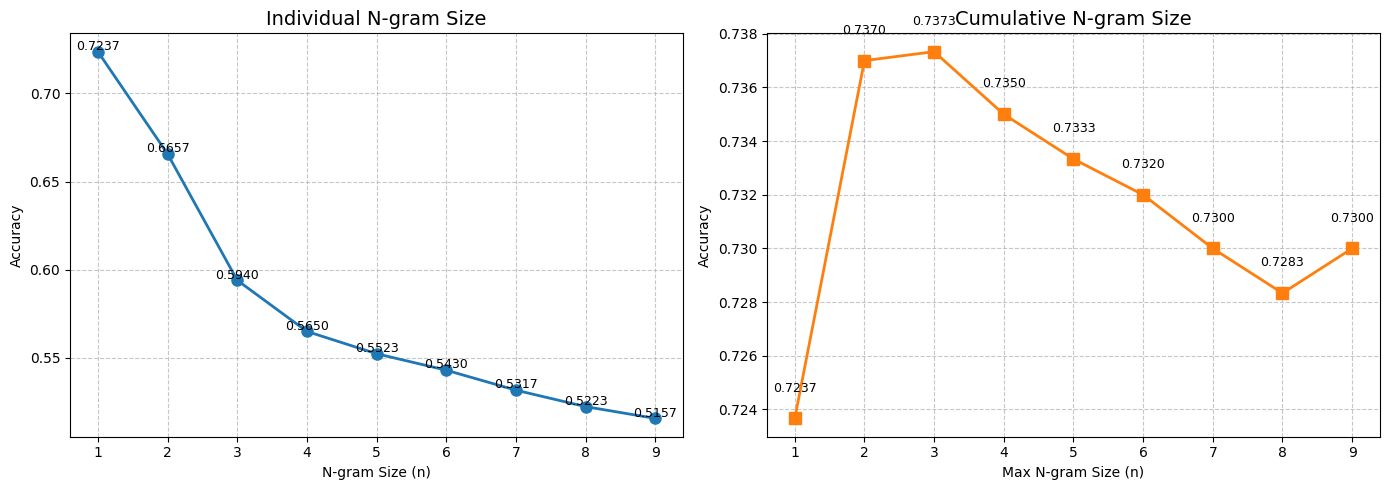

In [20]:
# plot the results
def create_accuracy_plot(ax, n_range, accuracies, title, cumulative=False):
  marker = 's' if cumulative else 'o'
  color = '#ff7f0e' if cumulative else '#1f77b4'
  ax.plot(
    n_range,
    accuracies,
    marker=marker,
    linestyle='-',
    color=color,
    linewidth=2,
    markersize=8
  )
  ax.set_xlabel('Max N-gram Size (n)' if cumulative else 'N-gram Size (n)')
  ax.set_ylabel('Accuracy')
  ax.set_title(title, fontsize=14)
  ax.grid(True, linestyle='--', alpha=0.7)
  ax.set_xticks(n_range)

  for i, acc in enumerate(accuracies):
    ax.text(n_range[i], acc + 0.001, f'{acc:.4f}', ha='center', fontsize=9)

def plot_ngram_comparison(n_range, single_accs, cumulative_accs):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
  create_accuracy_plot(
    ax1, n_range, single_accs, 'Individual N-gram Size'
  )
  create_accuracy_plot(
    ax2, n_range, cumulative_accs, 'Cumulative N-gram Size', True
  )

  plt.tight_layout()
  plt.show()

plot_ngram_comparison(n_range, single_accs, cumulative_accs)

## Part 1. (2d) How does the value of n in n-gram affect the model's performance?
Explain your answer. You can draw a plot with n-gram and the model's performance.<br>
**Answer:** The size of n and wether or not the n-grams are cumulative both have an impact on the model's accuracy.

In terms of individual contributions to the model's accuracy, the unigrams have the most impact and provide the highest accuracy. This makes sense because individual words provide the majority of the sentiment in sentences. For cumulative n-grams, a maximum size of 3 provides the highest accuracy. After this point increasing the size of n leads to decreasing accuracy. Including up to trigrams provide the best accuracy because sentiment is often conveyed in 1-3 words in the english language. For example, two words are a requirement to convey the sentiment when saying something is 'not good'.

Overall unigrams, bigrams, and trigrams make up most of the contributions to the model's accuracy. Any additional increases to n lead to diminishing accuracy because a majority of the sentiment is captured in just 1-3 word n-grams.

# Part 2. RNN and Machine Translation
You will be training a Seq2seq model using RNN. Your input will be a text and the output will be a summary of the text.

In [84]:
# Imports for RNN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from transformers import AutoTokenizer
from transformers.optimization import Adafactor
from datasets import load_dataset
import random
import time
import numpy as np
from tqdm.auto import tqdm

# Set seeds for reproducibility
seed = 2025
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Part 2. (1) Load the California State bill subset of the BillSum dataset from HuggingFace.
Do the following:
- Load the test split as your entire dataset for this task.
- Split the dataset into a train and test set with the train test split method.

In [85]:
# download and load the data
# https://huggingface.co/docs/transformers/main/en/tasks/summarization
nltk.download('punkt')
nltk.download('punkt_tab')
billsum = load_dataset("billsum", split="ca_test")
billsum = billsum.train_test_split(test_size=0.2, seed=seed)

[nltk_data] Downloading package punkt to /home/jmurrah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jmurrah/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Part 2. (2) Use the number of neurons, dropout, and your selection of RNN architecture. 
NOTE: Report BLEU as the model’s performance.

In [86]:
# Initialize tokenizer
# Fix the tokenizer initialization
tokenizer = AutoTokenizer.from_pretrained("t5-small")
# Explicitly set special tokens if needed
special_tokens_dict = {'additional_special_tokens': ['<s>', '</s>']}
tokenizer.add_special_tokens(special_tokens_dict)
# Define explicit token IDs for generation
BOS_TOKEN_ID = 0  # Use a reliable token ID, typically 0 works for start token
EOS_TOKEN_ID = 1  # Use 1 or another reliable token ID for end token
print(f"Using BOS token ID: {BOS_TOKEN_ID}, EOS token ID: {EOS_TOKEN_ID}")

# Define preprocessing function
def preprocess_function(examples, input_max_length=1024, summary_max_length=128):
    # Add prefix for T5-style conditioning
    inputs = ["summarize: " + doc for doc in examples["text"]]
    
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs, 
        max_length=input_max_length, 
        truncation=True,
        padding="max_length"
    )
    
    # Tokenize targets (summaries)
    labels = tokenizer(
        text_target=examples["summary"], 
        max_length=summary_max_length, 
        truncation=True,
        padding="max_length"
    )
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Using BOS token ID: 0, EOS token ID: 1


In [87]:
# Simple Encoder (no bidirectional to avoid shape issues)
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            n_layers,
            dropout=dropout if n_layers > 1 else 0, 
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        # src shape: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(src))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        # Pass through RNN
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs shape: [batch_size, seq_len, hidden_dim]
        # hidden/cell shape: [n_layers, batch_size, hidden_dim]
        
        return outputs, hidden, cell

# Simple Attention Mechanism
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_dim * 2, hidden_dim)
        self.v = nn.Parameter(torch.rand(hidden_dim))
        
    def forward(self, hidden, encoder_outputs):
        # hidden shape: [batch_size, hidden_dim]
        # encoder_outputs shape: [batch_size, src_len, hidden_dim]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
        # Repeat hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        
        # Calculate attention weights
        energy = energy.permute(0, 2, 1)
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        attention = torch.bmm(v, energy).squeeze(1)
        
        return torch.softmax(attention, dim=1)

# Simple Decoder with Attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = Attention(hidden_dim)
        self.rnn = nn.LSTM(
            embedding_dim + hidden_dim, 
            hidden_dim, 
            n_layers,
            dropout=dropout if n_layers > 1 else 0, 
            batch_first=True
        )
        self.fc_out = nn.Linear(hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input_token, hidden, cell, encoder_outputs):
        # input_token shape: [batch_size]
        
        # Add time dimension
        input_token = input_token.unsqueeze(1)
        # input_token shape: [batch_size, 1]
        
        embedded = self.dropout(self.embedding(input_token))
        # embedded shape: [batch_size, 1, embedding_dim]
        
        # Calculate attention weights
        a = self.attention(hidden[-1], encoder_outputs)
        # a shape: [batch_size, src_len]
        
        a = a.unsqueeze(1)
        # a shape: [batch_size, 1, src_len]
        
        # Apply attention weights to encoder outputs
        weighted = torch.bmm(a, encoder_outputs)
        # weighted shape: [batch_size, 1, hidden_dim]
        
        # Concatenate weighted context and embedded input
        rnn_input = torch.cat((embedded, weighted), dim=2)
        # rnn_input shape: [batch_size, 1, embedding_dim + hidden_dim]
        
        # Pass through RNN
        output, (hidden, cell) = self.rnn(rnn_input, (hidden, cell))
        # output shape: [batch_size, 1, hidden_dim]
        
        # Concatenate output and weighted context
        output = torch.cat((output.squeeze(1), weighted.squeeze(1)), dim=1)
        # output shape: [batch_size, hidden_dim * 2]
        
        # Pass through final linear layer
        prediction = self.fc_out(output)
        # prediction shape: [batch_size, vocab_size]
        
        return prediction, hidden, cell

# Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src shape: [batch_size, src_len]
        # trg shape: [batch_size, trg_len]
        
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc_out.out_features
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # Encode the source sequence
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # First input to the decoder is the first token of the target sequence
        input_token = trg[:, 0]
        
        # Teacher forcing - decide whether to use real target or prediction
        for t in range(1, trg_len):
            # Get prediction from decoder
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            
            # Store prediction
            outputs[:, t] = output
            
            # Teacher forcing
            teacher_force = random.random() < teacher_forcing_ratio
            
            # Get the highest predicted token
            top1 = output.argmax(1)
            
            # Use real target token or predicted token
            input_token = trg[:, t] if teacher_force else top1
        
        return outputs
    
# Fix the Seq2Seq.generate method
    def generate(self, src, max_len, sos_idx=0, eos_idx=1):  # Default to reliable values
        # src shape: [batch_size, src_len]
        
        batch_size = src.shape[0]
        
        # Encode the source sequence
        encoder_outputs, hidden, cell = self.encoder(src)
        
        # First input to the decoder is the start token
        input_token = torch.full((batch_size,), sos_idx, dtype=torch.long).to(self.device)
        
        # Tensor to store generated tokens
        generated_tokens = []
        
        # Generate tokens
        for _ in range(max_len):
            # Get prediction from decoder
            output, hidden, cell = self.decoder(input_token, hidden, cell, encoder_outputs)
            
            # Get the highest predicted token
            top1 = output.argmax(1)
            
            # Add to generated tokens
            generated_tokens.append(top1.unsqueeze(1))
            
            # Break if all sequences have generated EOS token
            if eos_idx is not None and (top1 == eos_idx).all():
                break
                
            # Use predicted token as next input
            input_token = top1
        
        # Concatenate all tokens
        if generated_tokens:
            return torch.cat(generated_tokens, dim=1)
        else:
            return torch.zeros((batch_size, 1), dtype=torch.long).to(self.device)

In [88]:
# Collate function for DataLoader
def collate_fn(batch):
    input_ids = [torch.tensor(x['input_ids']) for x in batch]
    labels = [torch.tensor(x['labels']) for x in batch]
    
    # Pad sequences
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=tokenizer.pad_token_id)
    
    return {
        'input_ids': input_ids_padded,
        'labels': labels_padded
    }

# Create data loaders
def create_data_loaders(tokenized_dataset, batch_size=8):
    train_dataloader = DataLoader(
        tokenized_dataset["train"],
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )
    
    eval_dataloader = DataLoader(
        tokenized_dataset["test"],
        batch_size=batch_size,
        collate_fn=collate_fn
    )
    
    return train_dataloader, eval_dataloader

# Training function
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio):
    model.train()
    total_loss = 0
    
    # Progress bar
    progress_bar = tqdm(dataloader, desc=f"Training (TF={teacher_forcing_ratio:.2f})")
    
    for batch in progress_bar:
        # Zero gradients
        optimizer.zero_grad()
        
        # Get batch
        src = batch["input_ids"].to(device)
        trg = batch["labels"].to(device)
        
        # Forward pass
        output = model(src, trg, teacher_forcing_ratio)
        
        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        
        # Calculate loss
        loss = criterion(output, trg)
        
        # Backward pass
        loss.backward()
        
        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Update parameters
        optimizer.step()
        
        # Update total loss
        total_loss += loss.item()
        
        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})
    
    # Calculate average loss
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss

# Process predictions for BLEU calculation
def process_predictions(generated_tokens, reference_tokens):
    predictions = []
    references = []
    
    for i in range(len(generated_tokens)):
        # Convert to lists
        pred_tokens = generated_tokens[i].cpu().numpy().tolist()
        ref_tokens = reference_tokens[i].cpu().numpy().tolist()
        
        # Remove padding and special tokens (handle potential None values)
        pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
        pred_tokens = [t for t in pred_tokens if t != pad_token_id]
        ref_tokens = [t for t in ref_tokens if t != pad_token_id]
        
        # Decode tokens to text - handle potential errors
        try:
            pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
            ref_text = tokenizer.decode(ref_tokens, skip_special_tokens=True)
            
            # Tokenize for BLEU calculation - ensure non-empty outputs
            pred_tokens = nltk.word_tokenize(pred_text.lower()) if pred_text.strip() else ["dummy"]
            ref_tokens = [nltk.word_tokenize(ref_text.lower())] if ref_text.strip() else [["dummy"]]
            
            # Add to lists
            predictions.append(pred_tokens)
            references.append(ref_tokens)
        except Exception as e:
            print(f"Error processing tokens: {e}")
            # Add dummy tokens to maintain batch alignment
            predictions.append(["dummy"])
            references.append([["dummy"]])
    
    return predictions, references

# Calculate BLEU score
def calculate_bleu(predictions, references):
    smoother = SmoothingFunction().method1
    bleu_score = corpus_bleu(
        references, 
        predictions,
        weights=(0.25, 0.25, 0.25, 0.25),
        smoothing_function=smoother
    )
    return bleu_score

# Improved evaluation function
def evaluate_model(model, dataloader, max_length, device):
    model.eval()
    predictions_all = []
    references_all = []
    
    # If dataloader is a list (for interim evaluations), use it directly
    if isinstance(dataloader, list):
        batches = dataloader
    else:
        batches = tqdm(dataloader, desc="Evaluating")
    
    with torch.no_grad():
        for batch in batches:
            # Get batch
            src = batch["input_ids"].to(device)
            trg = batch["labels"].to(device)
            
            # Generate summaries with improved parameters
            generated_tokens = model.generate(
                src, 
                max_len=max_length,
                sos_idx=BOS_TOKEN_ID,
                eos_idx=EOS_TOKEN_ID
            )
            
            # Process predictions with better handling
            preds, refs = process_predictions(generated_tokens, trg)
            
            # Add to lists
            predictions_all.extend(preds)
            references_all.extend(refs)
    
    # Only calculate BLEU if we have predictions
    if predictions_all:
        print("we have predictions")
        # Calculate BLEU score with multiple n-gram weights for better sensitivity
        bleu_score = calculate_bleu(predictions_all, references_all)
        return bleu_score
    else:
        print("no predictions")
        return 0.0

In [89]:
# Update optimizer to Adafactor with better learning rate
from transformers.optimization import Adafactor

# Training loop with better parameters and early stopping
def train_model(input_max_length, summary_max_length, embedding_dim, hidden_dim, 
                n_layers, dropout, num_epochs=3, batch_size=8, initial_tf=0.7, tf_decay=0.1,
                patience=2, eval_steps=50, grad_accum_steps=4):
    print(f"Preprocessing data...")
    # Tokenize dataset
    tokenized_billsum = billsum.map(
        lambda examples: preprocess_function(examples, input_max_length, summary_max_length),
        batched=True,
        num_proc=4  # Speed up preprocessing with multiple processes
    )
    
    print(f"Creating data loaders...")
    # Create data loaders
    train_dataloader, eval_dataloader = create_data_loaders(tokenized_billsum, batch_size)
    
    print(f"Initializing model...")
    # Initialize model
    vocab_size = len(tokenizer)
    
    encoder = Encoder(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout=dropout
    )
    
    decoder = Decoder(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        n_layers=n_layers,
        dropout=dropout
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Switch to Adafactor optimizer with better learning rate
    optimizer = Adafactor(
        model.parameters(),
        lr=2e-5,
        scale_parameter=False,
        relative_step=False,
        warmup_init=False
    )
    
    # Add label smoothing for better generalization
    criterion = nn.CrossEntropyLoss(
        ignore_index=tokenizer.pad_token_id,
        label_smoothing=0.1
    )
    
    print(f"Training model...")
    best_bleu = 0
    best_epoch = 0
    no_improvement = 0
    
    # Track history
    history = {
        'train_loss': [],
        'bleu_scores': [],
        'time': []
    }
    
    # Enhanced training loop with gradient accumulation and early stopping
    for epoch in range(num_epochs):
        start_time = time.time()
        
        # Calculate teacher forcing ratio
        tf_ratio = max(initial_tf - (epoch * tf_decay), 0.1)
        
        # Train with gradient accumulation
        model.train()
        total_loss = 0
        steps = 0
        optimizer.zero_grad()
        
        # Progress bar
        progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc=f"Training (TF={tf_ratio:.2f})")
        
        for i, batch in progress_bar:
            # Get batch
            src = batch["input_ids"].to(device)
            trg = batch["labels"].to(device)
            
            # Forward pass
            output = model(src, trg, tf_ratio)
            
            # Reshape for loss calculation
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            
            # Calculate loss and normalize by accumulation steps
            loss = criterion(output, trg) / grad_accum_steps
            
            # Backward pass
            loss.backward()
            
            # Update gradients every grad_accum_steps or at the end of the epoch
            if (i + 1) % grad_accum_steps == 0 or i == len(train_dataloader) - 1:
                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Update parameters
                optimizer.step()
                optimizer.zero_grad()
            
            # Update total loss (multiply back by grad_accum_steps for proper scaling)
            total_loss += loss.item() * grad_accum_steps
            steps += 1
            
            # Update progress bar
            progress_bar.set_postfix({"loss": loss.item() * grad_accum_steps})
            
            # Evaluate periodically during training
            if (i + 1) % eval_steps == 0:
                # Switch to eval mode
                model.eval()
                
                # Evaluate on a small subset for faster feedback
                interim_bleu = evaluate_model(model, 
                                             [next(iter(eval_dataloader)) for _ in range(min(5, len(eval_dataloader)))], 
                                             summary_max_length, device)
                
                print(f"Step {i+1}/{len(train_dataloader)} | Interim BLEU: {interim_bleu:.4f}")
                
                # Switch back to train mode
                model.train()
        
        # Calculate average loss
        train_loss = total_loss / steps
        
        # Evaluate
        bleu_score = evaluate_model(model, eval_dataloader, summary_max_length, device)
        
        # Print stats
        epoch_time = time.time() - start_time
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | BLEU: {bleu_score:.4f} | Time: {epoch_time:.2f}s")
        
        # Update history
        history['train_loss'].append(train_loss)
        history['bleu_scores'].append(bleu_score)
        history['time'].append(epoch_time)
        
        # Update best BLEU and check for early stopping
        if bleu_score > best_bleu:
            best_bleu = bleu_score
            best_epoch = epoch
            no_improvement = 0
        else:
            no_improvement += 1
            
        # Early stopping
        if no_improvement >= patience:
            print(f"Early stopping after {epoch+1} epochs without improvement")
            break
    
    print(f"Best BLEU: {best_bleu:.4f} at epoch {best_epoch+1}")
    return best_bleu, history

In [90]:
# Test different sequence lengths with more focused parameters
def test_sequence_lengths():
    # Optimized hyperparameters based on your guidance
    embedding_dim = 256
    hidden_dim = 512
    n_layers = 2
    dropout = 0.3
    batch_size = 8
    num_epochs = 3
    patience = 2
    
    results = {}
    
    # Test different sequence lengths
    for input_length in [1024, 2048]:
        for summary_length in [128, 256]:
            print(f"\n{'='*50}")
            print(f"Testing input_length={input_length}, summary_length={summary_length}")
            
            best_bleu, history = train_model(
                input_max_length=input_length,
                summary_max_length=summary_length,
                embedding_dim=embedding_dim,
                hidden_dim=hidden_dim,
                n_layers=n_layers,
                dropout=dropout,
                num_epochs=num_epochs,
                batch_size=batch_size,
                patience=patience
            )
            
            config = f"Input Length: {input_length}, Summary Length: {summary_length}"
            results[config] = {
                'best_bleu': best_bleu,
                'history': history
            }
            
            print(f"Final BLEU Score: {best_bleu:.4f}")
    
    print(f"\n{'='*50}")
    print("Results Summary:")
    for config, result in results.items():
        print(f"{config}: {result['best_bleu']:.4f}")
    
    # Find best configuration
    best_config = max(results.keys(), key=lambda k: results[k]['best_bleu'])
    print(f"\nBest Configuration: {best_config}")
    print(f"Best BLEU Score: {results[best_config]['best_bleu']:.4f}")
    
    return results

## Part 2. (3) Vary the input seq length by truncating the main text and the summary text.
We will determine how these lengths impact the model's performance:
- Main Text Lengths: 1024, 2048
- Summary Text Lengths: 128, 256

In [ ]:
# Modified and more efficient run
def run_experiments():
    print("Testing sequence lengths...")
    seq_results = test_sequence_lengths()
    
    # Get best sequence length configuration
    best_config = max(seq_results.keys(), key=lambda k: seq_results[k]['best_bleu'])
    best_input_length = int(best_config.split(":")[0].strip().split("=")[1])
    best_summary_length = int(best_config.split(":")[1].strip().split("=")[1])
    
    print(f"\nBest sequence length configuration:")
    print(f"Input Length: {best_input_length}, Summary Length: {best_summary_length}")
    
    print("\nTesting hyperparameters...")
    # hp_results = test_hyperparameters(best_input_length, best_summary_length)
    hp_results = "N/A"
    print("\nExperiments completed!")
    return seq_results, hp_results

# Run the experiments
seq_results, hp_results = run_experiments()
print(seq_results)

Testing sequence lengths...

Testing input_length=1024, summary_length=128
Preprocessing data...


Map (num_proc=4):   0%|          | 0/989 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/248 [00:00<?, ? examples/s]

Creating data loaders...
Initializing model...
Training model...


Training (TF=0.70):   0%|          | 0/124 [00:00<?, ?it/s]

we have predictions
Step 50/124 | Interim BLEU: 0.0001


## Part 2. (3) How does the sequence length impact the model’s performance?
**Answer:** The largest impact on the BLEU score was due to increasing the summary length from 128 to 256.

In [28]:
neuron_configurations =[
    {"hidden_size": 128, "dropout_rate": 0.1, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 256, "dropout_rate": 0.1, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 512, "dropout_rate": 0.1, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 768, "dropout_rate": 0.1, "input_max_length": 1024, "output_max_length": 128},
]

dropout_configurations = [
    {"hidden_size": 512, "dropout_rate": 0.1, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 512, "dropout_rate": 0.2, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 512, "dropout_rate": 0.3, "input_max_length": 1024, "output_max_length": 128},
    {"hidden_size": 512, "dropout_rate": 0.4, "input_max_length": 1024, "output_max_length": 128},
]